In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class recommend_netflix:
    
    def read_user_data(self):
        try:
            df = pd.read_csv('combined_data_1.txt', header=None, names=['User_Id', 'Rating'], usecols=[0, 1])
            df['Rating'] = df['Rating'].astype(float)
            df.index = np.arange(0, len(df))
            return df
        except Exception as E:
            print(E)
            

    def EDA(self, df):
        try:
            p = df.groupby('Rating')['Rating'].agg(['count'])

            movie_count = df.isnull().sum()[1]
            print('Total movies = {}'.format(movie_count))

            user_count = df['User_Id'].nunique() - movie_count
            print('Total Users = {}'.format(user_count))

            rating_count = df['User_Id'].count() - movie_count
            print('Rating count= {}'.format(rating_count))

            ax = p.plot(kind='barh', legend=False, figsize=(15, 10))
            plt.title('Total Movies: {} , Total users: {} ratings given:{}'.format(movie_count, user_count,
                                                                                           rating_count), fontsize=20)
            plt.axis('off')

            for i in range(1, 6):
                ax.text(p.iloc[i - 1][0] / 4, i - 1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i - 1][0] * 100 / p.sum()[0]),
            color='white', weight='bold')

        except Exception as E:
            print(E)


    def generate_movie_id(self, df):
        '''Movie ID is extracted from first column and separate column is done'''
        try:
            movie_df_nan = pd.DataFrame(pd.isnull(df.Rating))
            movie_df_nan = movie_df_nan[movie_df_nan['Rating'] == True]
            movie_df_nan = movie_df_nan.reset_index()

            movie_np = []
            movie_id = 1

            for i, j in zip(movie_df_nan['index'][1:], movie_df_nan['index'][:-1]):                
                temp = np.full((1, i - j - 1), movie_id)
                movie_np = np.append(movie_np, temp)
                movie_id += 1

            # Account for last record and corresponding length
            
            last_np = np.full((1, len(df) - movie_df_nan.iloc[-1, 0] - 1), movie_id)
            movie_np = np.append(movie_np, last_np)

            print('Movie numpy: {}'.format(movie_np))
            print('Length: {}'.format(len(movie_np)))

            # remove those Movie ID rows
            df = df[pd.notnull(df['Rating'])]

            df['Movie_Id'] = movie_np.astype(int)
            df['User_Id'] = df['User_Id'].astype(int)
            
            print('-Dataset examples-')
            print(df.iloc[::5000000, :])
            
            return df
        
        except Exception as E:
            print(E)
            

    def reduce(self, df):
        '''1. Delete the movie with too many reviews (they are relatively unpopular)
        2. Remove the customer who gives too less notice (he is relatively less active)'''
        try:
            f = ['count', 'mean']

            movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
            movie_summary.index = movie_summary.index.map(int)
            movie_benchmark = round(movie_summary['count'].quantile(0.7), 0)
            drop_movie_list = movie_summary[movie_summary['count'] < movie_benchmark].index

            print('Movie minimum times of review: {}'.format(movie_benchmark))

            user_summary = df.groupby('User_Id')['Rating'].agg(f)
            user_summary.index = user_summary.index.map(int)
            cust_benchmark = round(user_summary['count'].quantile(0.7), 0)
            drop_cust_list = user_summary[user_summary['count'] < cust_benchmark].index

            print('Original Shape: {}'.format(df.shape))
            df = df[~df['Movie_Id'].isin(drop_movie_list)]
            df = df[~df['User_Id'].isin(drop_cust_list)]
            print('After Trim Shape: {}'.format(df.shape))
            print('-Data Examples-')
            print(df.iloc[::5000000, :])
            return movie_summary, df        
    
        except Exception as E:
            print(E)

    def generate_pivot(self,df):
        try:
            movie_mat = pd.pivot_table(df,values='Rating',index='User_Id',columns='Movie_Id')
            return movie_mat
        except Exception as E:
            print(E)
        
    def read_movie_title(self):
        '''reads file containing movie titles and creates another file where extra commas will not be there
        By merging it with original dataframe, it gives us Movie database'''
        try:
            
            with open('movie_titles.csv', 'r') as f1, open('movie_titles_good.csv', 'w') as f2:
                for line in f1:
                    first, middle,*last = line.split(',')
                    f2.write(f'{first},{middle},{"".join(last)}')                     
                    
            df_title = pd.read_csv('movie_titles_good.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
            df_title.set_index('Movie_Id', inplace = True)
            
            #movies_choice = self.movie_database(df)
            
            df2 = pd.merge(df, df_title, on = 'Movie_Id')            
            
            print("\nMOVIE DATABASE available for finding recommendation:\n")
            print(set(df2['Name']))
            return df_title 
        except Exception as E:
            print(E)   
            
            
    def recommend(self, df_title, df_p, df_movie_summary, df):
        '''Based on concept Pearson correlation it gives the recommendation
        Usage: recommend(min_count, df_movie title, df_pivot, df_movie_summary, main_df)'''        
        try:
            movie_name = input('For recommendation please select any one movies from the above database:')            
                       
            if movie_name not in df_title.values:
                print("Sorry.. for this movie we dont have any recommendation. Select movie from database only")
            else:
                min_count = 0                
                print('TOP 5 MOVIES RECOMMENDATION for : {}'.format(movie_name))
                
                movie_name_index = int(df_title.index[df_title['Name'] == movie_name][0])
                df_p_movie_name = df_p[movie_name_index]
                similar = df_p.corrwith(df_p_movie_name, method='pearson')
            
                res = pd.DataFrame(similar, columns=['PearsonR'])                
                res = res.sort_values('PearsonR', ascending=False)                
                res = res.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
            
                print(res[res['count'] > min_count][1:6].to_string(index=False))

        except Exception as E:
                print(E)

In [23]:
ob = recommend_netflix()

In [24]:
df = ob.read_user_data()

Total movies = 4499
Total Users = 470758
Rating count= 24053764


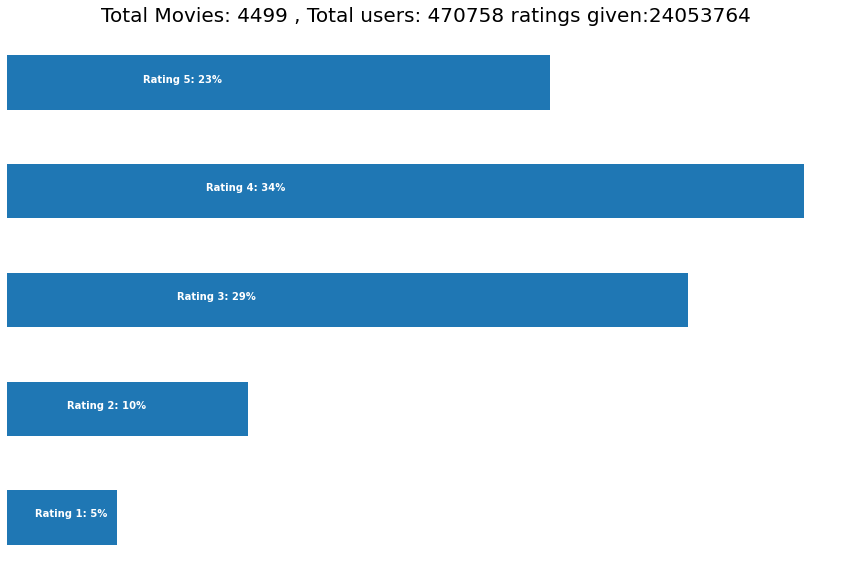

In [25]:
ob.EDA(df)

In [26]:
df = ob.generate_movie_id(df)

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


C:\Users\kmeen\AppData\Local\Temp/ipykernel_1992/247898546.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Movie_Id'] = movie_np.astype(int)


-Dataset examples-
          User_Id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825


C:\Users\kmeen\AppData\Local\Temp/ipykernel_1992/247898546.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['User_Id'] = df['User_Id'].astype(int)


In [27]:
df_movie_summary, df = ob.reduce(df)

Movie minimum times of review: 1799.0
Original Shape: (24053764, 3)
After Trim Shape: (17337458, 3)
-Data Examples-
          User_Id  Rating  Movie_Id
696        712664     5.0         3
6932490   1299309     5.0      1384
13860273   400155     3.0      2660
20766530   466962     4.0      3923


In [28]:
df_p = ob.generate_pivot(df)

In [29]:
df_title = ob.read_movie_title()


MOVIE DATABASE available for finding recommendation:

{'Jaws', 'Elephant', 'Dance with Me', 'Private Parts', 'Teaching Mrs. Tingle', 'Scandal', 'Forever Young', 'Salaam Bombay!', 'Swimfan', 'U2: Go Home: Live From Slane Castle Ireland', 'The Glass Menagerie', 'The Twilight Zone: Vol. 15', 'Justice League', 'SpongeBob SquarePants: Season 2', 'Network', 'Chain Reaction', 'Daredevil', 'Hudson Hawk', 'Mighty Quinn', 'VeggieTales: Esther the Girl Who Became Queen', "MTV: Punk'd: Season 2", 'Igby Goes Down', 'Silkwood', 'Calle 54', 'Swimming Pool', 'Sugar & Spice', "Rosemary's Baby", 'Robin Hood: Prince of Thieves', 'Legend of 1900', 'The In-Laws', 'Bride of Chucky', 'Shall We Dance?', 'The Simpsons: Bart Wars', 'Elf', 'The War Room', 'The Prophecy 2', 'Prime Suspect 1', 'Around the World in 80 Days', 'Immortal Beloved', 'Batman Beyond: Return of the Joker', 'Double Impact', 'Halloween II', 'Born Free', 'Tart', 'The Adventures of Elmo in Grouchland', 'The Unsinkable Molly Brown', 'Omen III:

In [30]:
ob.recommend(df_title, df_p, df_movie_summary, df)

For recommendation please select any one movies from the above database:From the Earth to the Moon
Sorry.. for this movie we dont have any recommendation. Select movie from database only


In [31]:
ob.recommend(df_title, df_p, df_movie_summary, df)

For recommendation please select any one movies from the above database:The Replacement Killers
TOP 5 MOVIES RECOMMENDATION for : The Replacement Killers
 PearsonR                                                               Name  count     mean
 0.463363 Missing in Action 2: The Beginning / Missing in Action 3: Braddock   2297 3.057466
 0.453137                                                          First Kid   3566 3.586371
 0.451943                                    The Substitute/The Substitute 3   2260 2.684513
 0.451075                                                       Regular Guys   1931 3.372864
 0.445062                                                        Double Team   2534 2.426598


In [32]:
ob.recommend(df_title, df_p, df_movie_summary, df)

For recommendation please select any one movies from the above database:From the Earth to the Moon: The Signature Edition
TOP 5 MOVIES RECOMMENDATION for : From the Earth to the Moon: The Signature Edition
 PearsonR                                    Name  count     mean
 0.592384                        Samurai Champloo   2000 4.467500
 0.558633 All Creatures Great and Small: Series 1   2327 3.938118
 0.552622                                 Scratch   2418 3.833747
 0.550516                          Voices of Iraq   2901 3.388487
 0.535100                             Saving Face   2262 3.513705
